In [1]:
import sys
sys.path.insert(1,'../code/')

import estim 


import config as conf
import numpy as np
from matplotlib import pyplot as plt

import healpy as hp

import load_maps as maps

import redshifts

To run this notebook you will need correlated kSZ and CMB maps, if you don't have your own and want to use these ones I used for testing please get in touch , I am happy to share them!

## some setup

In [2]:
'''
you choose the number of velocity bins you want here:
NBIN corresponds to ''pi-bins'' in ReCCO; the number of 
components in redshift space you assign to your Haar-expansion ofthe velocity.

nbin_tracer refers to the number of bins you have in your tracer

We are doing an example where we reconstruct 8 velocity bins with 8 maps of redshift-binned halos 

For something like a photometric galaxy survey you can have higher nbin_tracer although
note we have not tested the code for anything except nbin_tracer =1 and nbin_tracer = NBIN
'''

NBIN = 8              
conf.N_bins = NBIN

nbin_tracer = NBIN

assert (nbin_tracer == NBIN) or (nbin_tracer ==1)


In [3]:
c_mps  =  299792458
c_kmps = c_mps/1000

### load websky maps:

In [4]:
nside = 1024   #the nside of the maps in your analysis

npix = hp.nside2npix(nside)

zbinning = redshifts.binning(conf)

In [5]:

#here we load the websky kSZ map and primary CMB, ie our simulated data

websky_maps_folder = '/mnt/ceph/users/fmccarthy/kSZ/Websky_sims/'  #wherever you have saved it goes here
astropaint_folder = websky_maps_folder + 'AstroPaint/'

print("loading websky kSZ")

kszmap_websky = maps.ksz(nside,'websky',websky_maps_folder=websky_maps_folder)   # ksz map 

print("loading websky lensed CMB")

CMBmap = maps.CMB(nside,websky_maps_folder=websky_maps_folder,alm=False) # CMB alm 

print("loading astropainted kSZ")

kszmap_astropaint=maps.ksz(nside,'astropaint',astropaint_folder=astropaint_folder)   #the kSZ map that I made in astropaint from the websky halo catalogue

print("loading websky halo number counts")

Nhalos = maps.Nhalos(nside,NBIN,zbinning.zbins_chi,websky_maps_folder=websky_maps_folder)

print("loading websky tau")

taumaps = maps.tau(nside,NBIN,zbinning.zbins_chi,astropaint_folder=astropaint_folder)

loading websky kSZ


/mnt/home/fmccarthy/kszenv/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


loading websky lensed CMB
loading astropainted kSZ


/mnt/home/fmccarthy/kszenv/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


loading websky halo number counts
loading websky tau


### take measured C_ell of maps

We need theoretical power spectra to go into the estimator weights.

In principle these should come from a model. If they are incorrect there will be biases on the reconstruction. To avoid these, for testing purposes we use the measured power spectra (for now).

In [6]:

CMB_cl                 = hp.anafast(CMBmap,lmax=3*nside+2)
print("got CMB Cl")
ksz_cl_websky          = hp.anafast(kszmap_websky,lmax=3*nside+2)
print("got kSZ websky Cl")
ksz_cl_astropaint      = hp.anafast(kszmap_astropaint,lmax=3*nside+2)
print("got kSZ astropaint Cl")
cross_ksz_astrowebsky  = hp.anafast(kszmap_websky,kszmap_astropaint,lmax=3*nside+2)

print("got cross")

halo_cl = np.zeros((3*nside+3,NBIN,NBIN))
for x in range(0,NBIN):
        halo_cl[:,x,x] = hp.anafast(Nhalos[x],lmax=3*nside+2)
        
print("got halo cl")

halo_cross_tau_cl = np.zeros((3*nside+3,NBIN,NBIN))
for x in range(0,NBIN):
        halo_cross_tau_cl[:,x,x] = hp.anafast(Nhalos[x],taumaps[x],lmax=3*nside+2)
print("got tau cl")

got CMB Cl
got kSZ websky Cl
got kSZ astropaint Cl
got cross
got halo cl
got tau cl


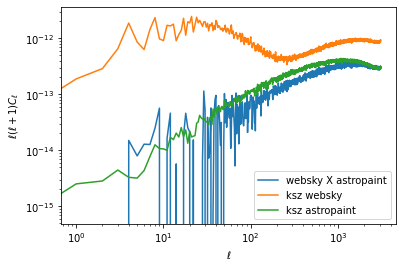

(0.0, 1.0)

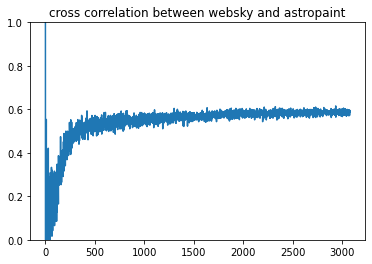

In [7]:
ells = np.arange(len(CMB_cl))

plt.loglog(ells*(ells+1)*cross_ksz_astrowebsky,label='websky X astropaint')
plt.loglog(ells*(ells+1)*ksz_cl_websky,label='ksz websky')



plt.loglog(ells*(ells+1)*ksz_cl_astropaint,label='ksz astropaint')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_\ell$')


plt.legend()
plt.show()
plt.title("cross correlation between websky and astropaint")
plt.plot(cross_ksz_astrowebsky/np.sqrt(ksz_cl_websky*ksz_cl_astropaint))

plt.ylim(0,1)

## now let's reconstruct the velocity

#### to reconstruct velocity you need to define an estimator object EST from estim.estimator():

In [8]:
nsideout= 32

In [9]:
EST = estim.estimator(data_lmax = 6144,conf_module = conf,nbin_tracer=nbin_tracer,include_Tlss=False) #we need to initialize an estimator object                           
# note that there are a lot more possible arguments for estimator()
# most of them are only relevant because they point to folders for precomputed C_ells
# which we do not use in this example

Default lss = 'g' . Modify with set_lss method.
Default N_fine_modes = 8. Modify with set_Nfine method.


#### The estimator object has a property called Cls which is a dictionary of the theoretical C_ells. Here we set them all to be the measured power spectra we calculated earlier.

In [10]:

Cls={}
Cls['lss-lss'] = np.zeros((3*nside+1,EST.nbin_tracer,EST.nbin_tracer))
Cls['taud-lss']= np.zeros((3*nside+1,NBIN,EST.nbin_tracer))
Cls['lss-taud']= np.zeros((3*nside+1,EST.nbin_tracer,NBIN))

Cls['lss-lss'] = halo_cl[:3*nside+1]
Cls['lss-taud'] = halo_cross_tau_cl[:3*nside+1]/EST.deltachi
Cls['taud-lss'] = halo_cross_tau_cl[:3*nside+1]/EST.deltachi

#include the below line to remove the large scale information from the cross correlation
#in the calculation of the noise

Cls['lss-taud'][:101]=0
Cls['taud-lss'][:101]=0


assert Cls['taud-lss'].shape[1] == EST.nbin
assert Cls['taud-lss'].shape[2] == EST.nbin_tracer



#for simplicity we set the T-lss cross correlation to 0 for now
Cls['T-lss']= np.zeros((3*nside+1,1,EST.nbin_tracer))
Cls['lss-T']= np.zeros((3*nside+1,EST.nbin_tracer,1))

EST.set_theory_Cls(Cls_dict=Cls)   #here we assign these C_ells to the estimator

#note that Cls['lss-lss'] should include noise!

#### Define the large scale structure tracers you are using (we are using the halo number counts)

In [11]:
lssmaps = Nhalos

#### First let's reconstruct with no primary CMB

In [12]:
# Using the astropainted kSZ

EST.Cls['T-T'] =  ksz_cl_astropaint[:3*nside+1,None,None]

Temperature = kszmap_astropaint

Astropaint_reconstruction_nocmb =  EST.reconstruct_velocity_from_maps(Temperature,lssmaps,nside,nsideout,fast=True)

# Using the Websky kSZ

EST.Cls['T-T'] =  ksz_cl_websky[:3*nside+1,None,None]

Temperature = kszmap_websky

Websky_reconstruction_nocmb =  EST.reconstruct_velocity_from_maps(Temperature,lssmaps,nside,nsideout,fast=True)



calculating noise
Theory noise ready
done
calculating reconstruction
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
done in 74.22898817062378
calculating noise
Theory noise ready
done
calculating reconstruction
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 ar

#### Now let's put in the primary CMB

In [33]:
# Using the astropainted kSZ

EST.Cls['T-T'] =  ksz_cl_astropaint[:3*nside+1,None,None]+CMB_cl[:3*nside+1,None,None]

Temperature = kszmap_astropaint+CMBmap

Astropaint_reconstruction_withcmb =  EST.reconstruct_velocity_from_maps(Temperature,lssmaps,nside,nsideout,fast=True)

# Using the Websky kSZ

EST.Cls['T-T'] =  ksz_cl_websky[:3*nside+1,None,None]+CMB_cl[:3*nside+1,None,None]

Temperature = kszmap_websky+CMBmap

Websky_reconstruction_withcmb =  EST.reconstruct_velocity_from_maps(Temperature,lssmaps,nside,nsideout,fast=True)

calculating noise
Theory noise ready
done
calculating reconstruction
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
done in 78.32438659667969
calculating noise
Theory noise ready
done
calculating reconstruction
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 ar

## Let's load the true velocities!


In [14]:
vtrue = maps.vmaps(nsideout,NBIN,zbinning.zbins_chi,websky_folder = websky_maps_folder)/c_kmps

/mnt/home/fmccarthy/kszenv/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


### Get the power / covariance matrices of the QEs and the correlation with the true velocity:

In [34]:
Cvv_true                       = maps.get_power(vtrue,diagonal=True)
Astropaint_recon_power_nocmb   = maps.get_power(Astropaint_reconstruction_nocmb['QE'],diagonal=True)
Astropaint_recon_power_withcmb = maps.get_power(Astropaint_reconstruction_withcmb['QE'],diagonal=True)
Websky_recon_power_nocmb       = maps.get_power(Websky_reconstruction_nocmb['QE'],diagonal=True)
Websky_recon_power_withcmb     = maps.get_power(Websky_reconstruction_withcmb['QE'],diagonal=True)

Astropaint_true_correlation_nocmb = maps.get_power(vtrue,Astropaint_reconstruction_nocmb['QE'],diagonal=True)
Astropaint_true_correlation_withcmb = maps.get_power(vtrue,Astropaint_reconstruction_withcmb['QE'],diagonal=True)
Websky_true_correlation_nocmb = maps.get_power(vtrue,Websky_reconstruction_nocmb['QE'],diagonal=True)
Websky_true_correlation_withcmb = maps.get_power(vtrue,Websky_reconstruction_nocmb['QE'],diagonal=True)



### Now let's compare our reconstruction to the true velocity by comparing the output qe with vRot

First for the astropainted reconstruction:

Overall this seems good. We seem to understand what is going on. There is a small bias in the first two bins of the high signal-to-noise reconstruction (ie, without CMB): possibly a bias from fine mode noise we haven't taken into account (ie, the velocity information should be decomposed into samller bins?)

Bin 0


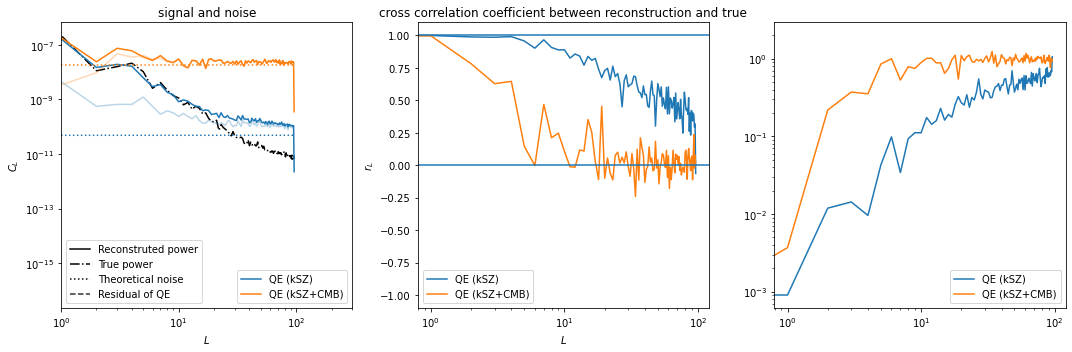

Bin 1


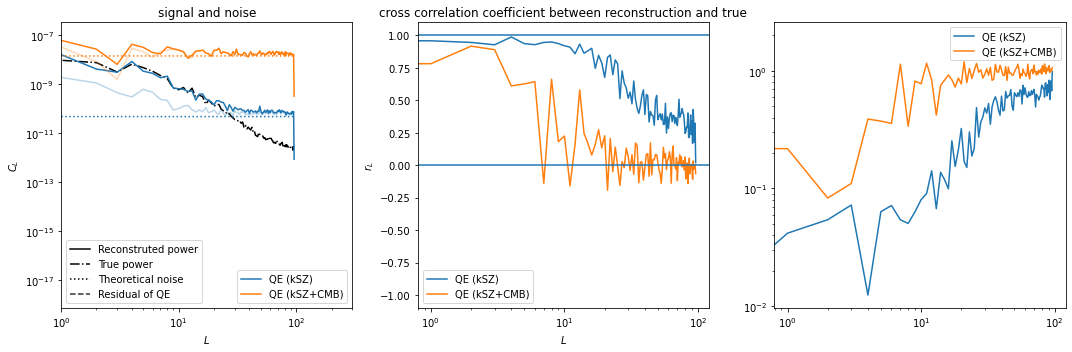

Bin 2


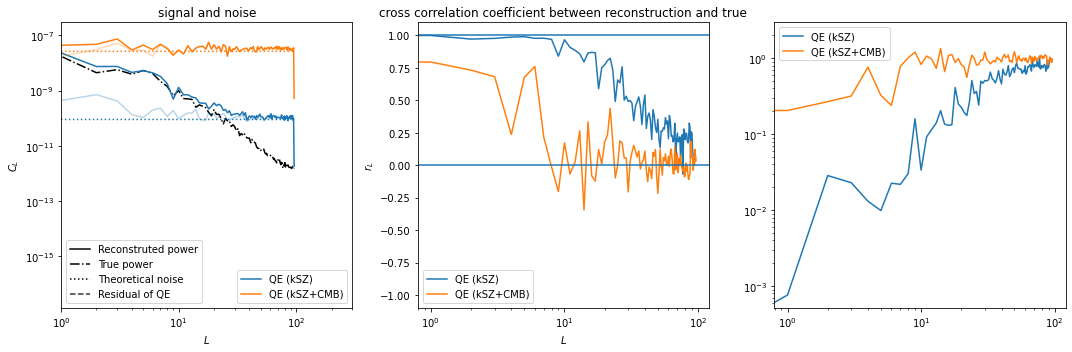

Bin 3


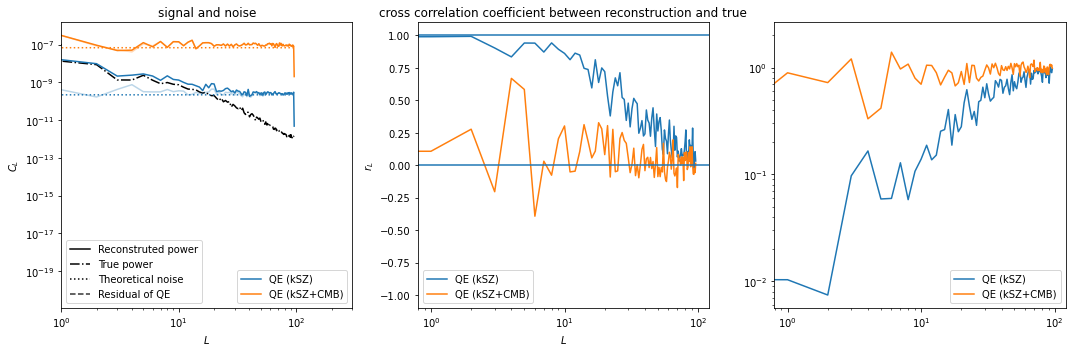

Bin 4


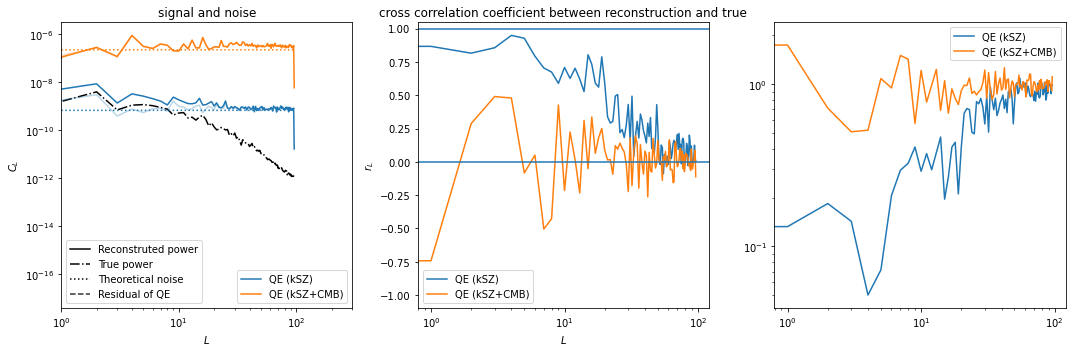

Bin 5


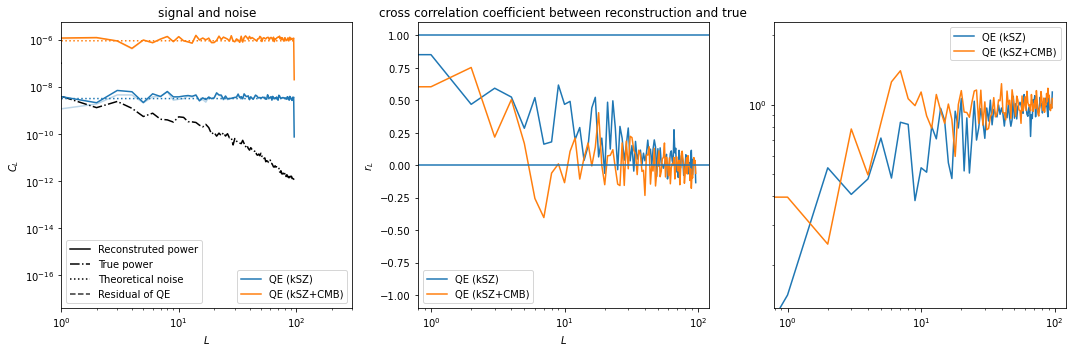

Bin 6


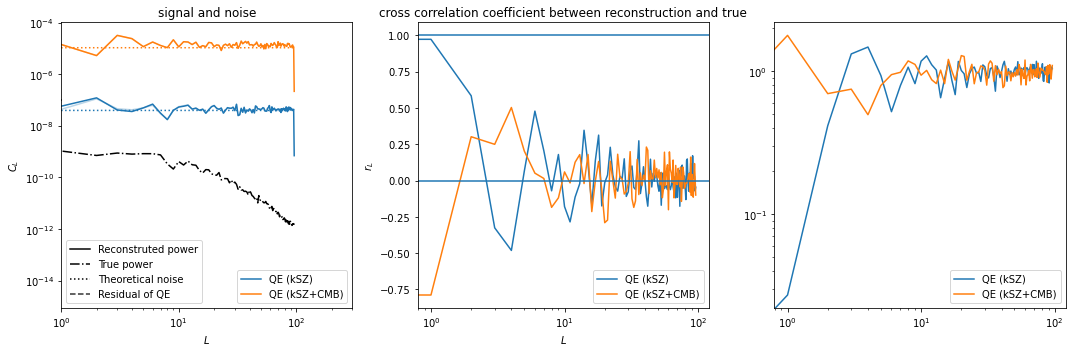

Bin 7


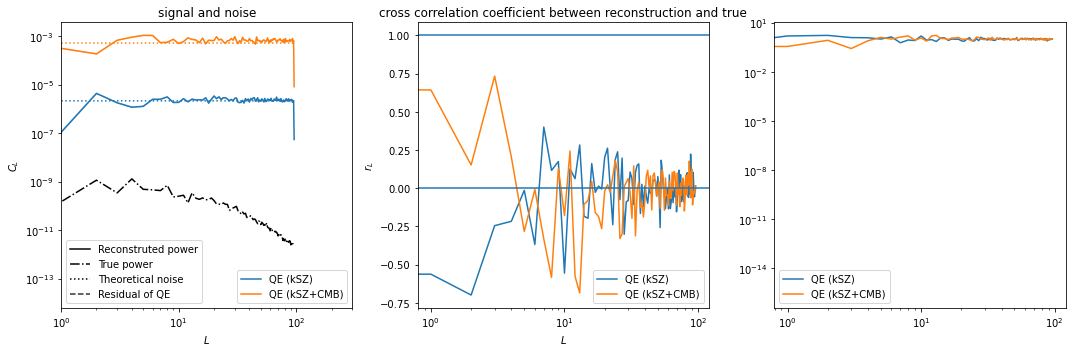

In [35]:

for x in range(0,NBIN):
    print("Bin "+str(x))
    plt.figure(figsize=(15,5))
    
    ax = plt.subplot(131)

    plt.loglog(Cvv_true[:,x,x],color='black',ls='-.') 

    l1,=plt.loglog(Astropaint_recon_power_nocmb[:,x,x],label='QE (kSZ)',)

    l2,=plt.loglog(Astropaint_recon_power_withcmb[:,x,x],label='QE (kSZ+CMB)',)

    plt.plot(Astropaint_reconstruction_nocmb['Noise'][x,x],color=l1.get_color(),ls=':')
    plt.plot(Astropaint_reconstruction_withcmb['Noise'][x,x],color=l2.get_color(),ls=':')


    plt.plot(hp.anafast(vtrue[x]-Astropaint_reconstruction_nocmb['QE'][x]),color=l1.get_color(),ls='-',alpha=0.3)
    plt.plot(hp.anafast(vtrue[x]-Astropaint_reconstruction_withcmb['QE'][x]),color=l2.get_color(),ls='-',alpha=0.3)

    plt.title("signal and noise")
    plt.xlabel(r'$L$')
    plt.ylabel(r'$C_L$')

    leg1 = plt.legend(loc= 'lower right')
    
    l1,=plt.plot([0,1e-7],color='black')
    l2,=plt.plot([0,1e-7],color='black',ls='-.')

    l3,=plt.plot([0,1e-7],color='black',ls=':')
    l4,=plt.plot([0,1e-7],color='black',ls='--',alpha=0.8)

    leg2 = plt.legend([l1,l2,l3,l4],
                      ['Reconstruted power','True power','Theoretical noise','Residual of QE'],
                      loc='lower left')
    ax.add_artist(leg1)
    
    plt.xlim(1,300)
    
    plt.subplot(132)


    plt.plot(Astropaint_true_correlation_nocmb[:,x,x]/np.sqrt(Cvv_true[:,x,x]*Astropaint_recon_power_nocmb[:,x,x]),label='QE (kSZ)')
    plt.plot(Astropaint_true_correlation_withcmb[:,x,x]/np.sqrt(Cvv_true[:,x,x]*Astropaint_recon_power_withcmb[:,x,x]),label='QE (kSZ+CMB)')

    plt.xscale("log")
    plt.xlabel(r"$L$")
    plt.ylabel(r"$r_L$")
    plt.axhline(1)
    plt.axhline(0)
    plt.title("cross correlation coefficient between reconstruction and true")
    plt.legend()
    
    plt.subplot(133)

    plt.plot(1-Astropaint_true_correlation_nocmb[:,x,x]/np.sqrt(Cvv_true[:,x,x]*Astropaint_recon_power_nocmb[:,x,x]),label='QE (kSZ)')
    plt.plot(1-Astropaint_true_correlation_withcmb[:,x,x]/np.sqrt(Cvv_true[:,x,x]*Astropaint_recon_power_withcmb[:,x,x]),label='QE (kSZ+CMB)')

    plt.yscale('log')

    plt.legend()
    plt.xscale("log")
    plt.tight_layout()
    plt.show()

Second for the websky reconstruction:

This is less good. There is a significant bias in higher bins. This is presumably due to the fact that the Cl (taudot x h)

Bin 0


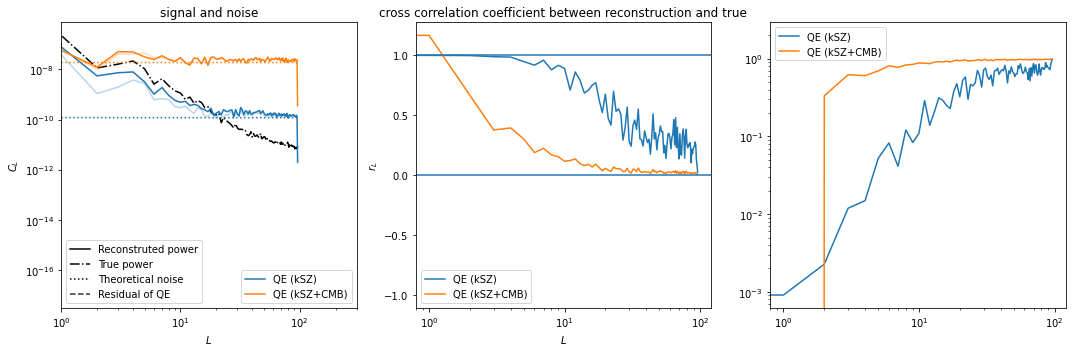

Bin 1


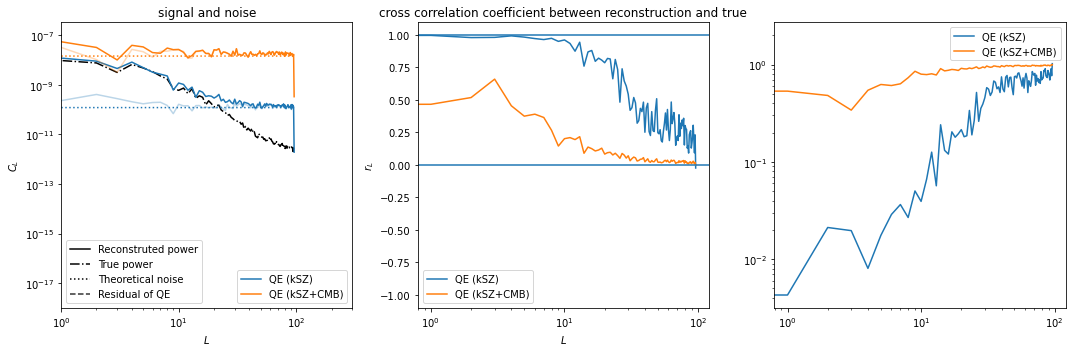

Bin 2


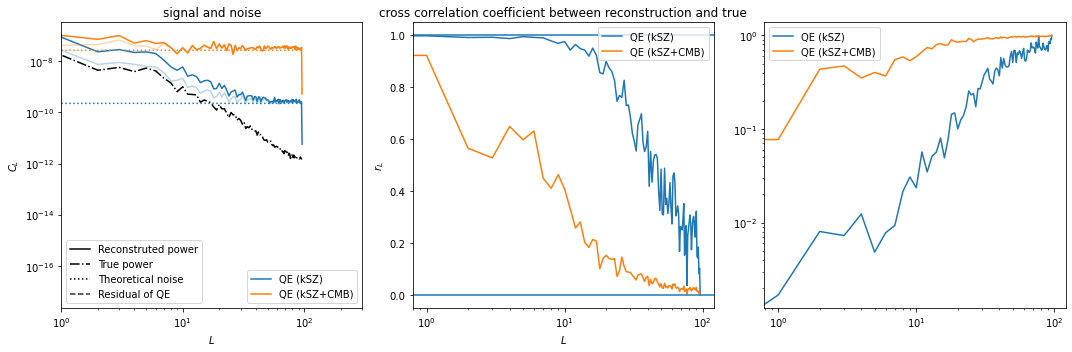

Bin 3


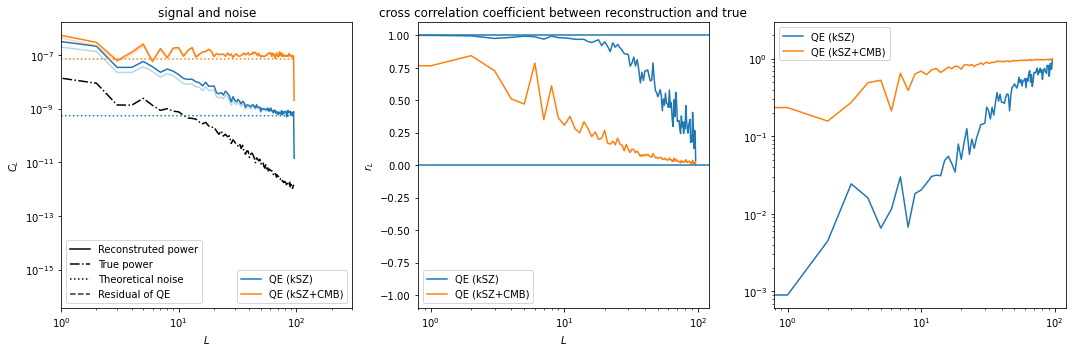

Bin 4


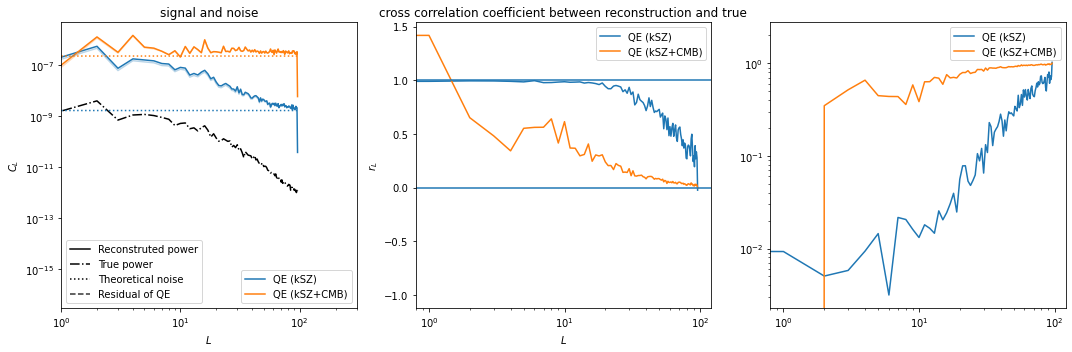

Bin 5


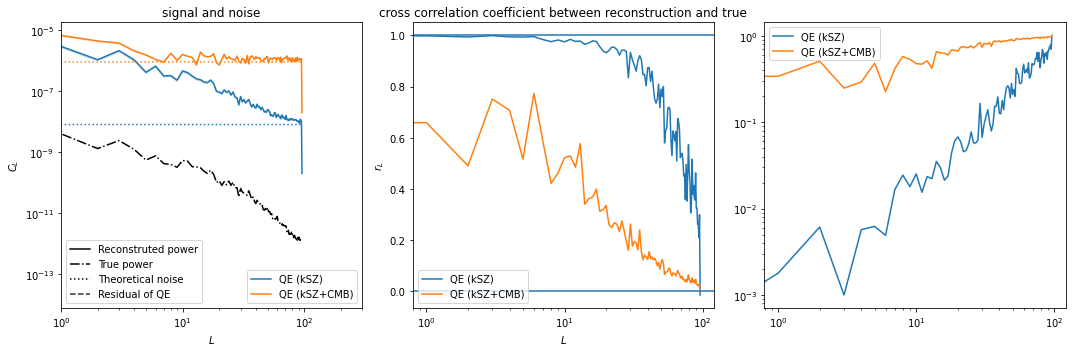

Bin 6


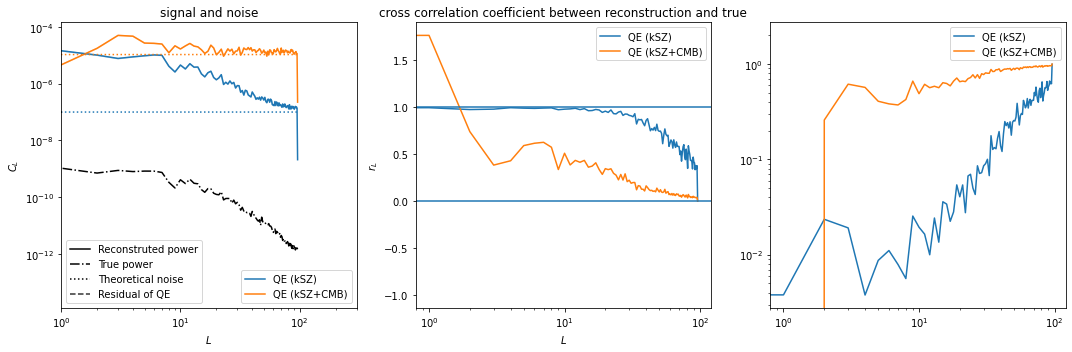

Bin 7


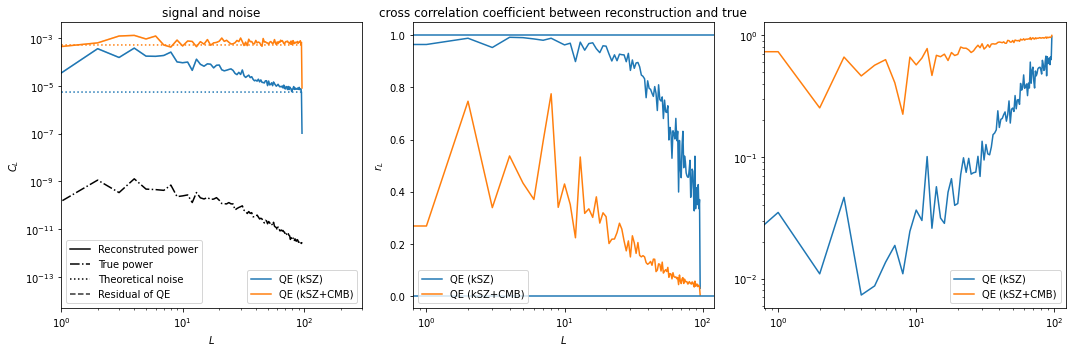

In [36]:

for x in range(0,NBIN):
    print("Bin "+str(x))
    plt.figure(figsize=(15,5))
    
    ax = plt.subplot(131)

    plt.loglog(Cvv_true[:,x,x],color='black',ls='-.') 

    l1,=plt.loglog(Websky_recon_power_nocmb[:,x,x],label='QE (kSZ)',)

    l2,=plt.loglog(Websky_recon_power_withcmb[:,x,x],label='QE (kSZ+CMB)',)

    plt.plot(Websky_reconstruction_nocmb['Noise'][x,x],color=l1.get_color(),ls=':')
    plt.plot(Websky_reconstruction_withcmb['Noise'][x,x],color=l2.get_color(),ls=':')


    plt.plot(hp.anafast(vtrue[x]-Websky_reconstruction_nocmb['QE'][x]),color=l1.get_color(),ls='-',alpha=0.3)
    plt.plot(hp.anafast(vtrue[x]-Websky_reconstruction_withcmb['QE'][x]),color=l2.get_color(),ls='-',alpha=0.3)

    plt.title("signal and noise")
    plt.xlabel(r'$L$')
    plt.ylabel(r'$C_L$')

    leg1 = plt.legend(loc= 'lower right')
    
    l1,=plt.plot([0,1e-7],color='black')
    l2,=plt.plot([0,1e-7],color='black',ls='-.')

    l3,=plt.plot([0,1e-7],color='black',ls=':')
    l4,=plt.plot([0,1e-7],color='black',ls='--',alpha=0.8)

    leg2 = plt.legend([l1,l2,l3,l4],
                      ['Reconstruted power','True power','Theoretical noise','Residual of QE'],
                      loc='lower left')
    ax.add_artist(leg1)
    
    plt.xlim(1,300)
    
    plt.subplot(132)


    plt.plot(Websky_true_correlation_nocmb[:,x,x]/np.sqrt(Cvv_true[:,x,x]*Websky_recon_power_nocmb[:,x,x]),label='QE (kSZ)')
    plt.plot(Websky_true_correlation_withcmb[:,x,x]/np.sqrt(Cvv_true[:,x,x]*Websky_recon_power_withcmb[:,x,x]),label='QE (kSZ+CMB)')

    plt.xscale("log")
    plt.xlabel(r"$L$")
    plt.ylabel(r"$r_L$")
    plt.axhline(1)
    plt.axhline(0)
    plt.title("cross correlation coefficient between reconstruction and true")
    plt.legend()
    
    plt.subplot(133)

    plt.plot(1-Websky_true_correlation_nocmb[:,x,x]/np.sqrt(Cvv_true[:,x,x]*Websky_recon_power_nocmb[:,x,x]),label='QE (kSZ)')
    plt.plot(1-Websky_true_correlation_withcmb[:,x,x]/np.sqrt(Cvv_true[:,x,x]*Websky_recon_power_withcmb[:,x,x]),label='QE (kSZ+CMB)')

    plt.yscale('log')

    plt.legend()
    plt.xscale("log")
    plt.tight_layout()
    plt.show()